In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import sys
import pickle
[
    sys.path.append(str(folder))
    for folder in pathlib.Path("../../src/").iterdir()
    if folder.is_dir()
]

# from fitting_utils import create_violation_interaction_pairs
# from experiment_sigma_sweep import ExperimentSigmaSweep
# from multiclass_logistic_regression import MultiClassLogisticRegression
from model_visualizer import *


sns.set_context("talk")
%load_ext autoreload
%autoreload 2

See `2023_12_10_explore_stim_viol_inters.ipynb` for plots with psychometrics & filters

## Compare Binary Multi with Interxs

In [3]:
file_path = "../../data/results/"
experiment_fname = "2023_11_20_compare_binary_multi_prev_violation_interactions.pkl"

In [4]:
# open experiment pkls
with open(file_path + experiment_fname, "rb") as f:
    experiment = pickle.load(f)

# init model vis
mvc = ModelVisualizerCompare(experiment)


ORDER = [
    "b_psytrack_features",
    # "m_psytrack_features",
    # "m_filter_prev_violation",
    "m_filter_prev_violation_stim_itrx",
    # "m_filter_prev_violation_all_itrx",x
]
df = mvc.find_best_fit(group="model_name")
df["model_name"] = pd.Categorical(df["model_name"], categories=ORDER, ordered=True)

# Sort the DataFrame
df = df.sort_values("model_name")

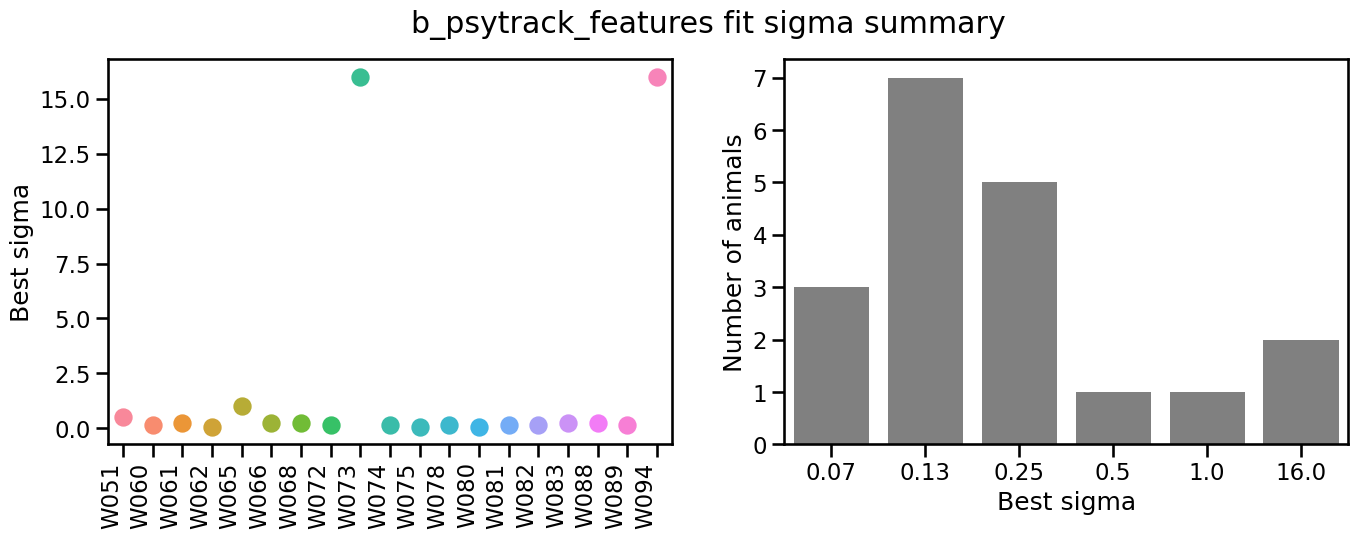

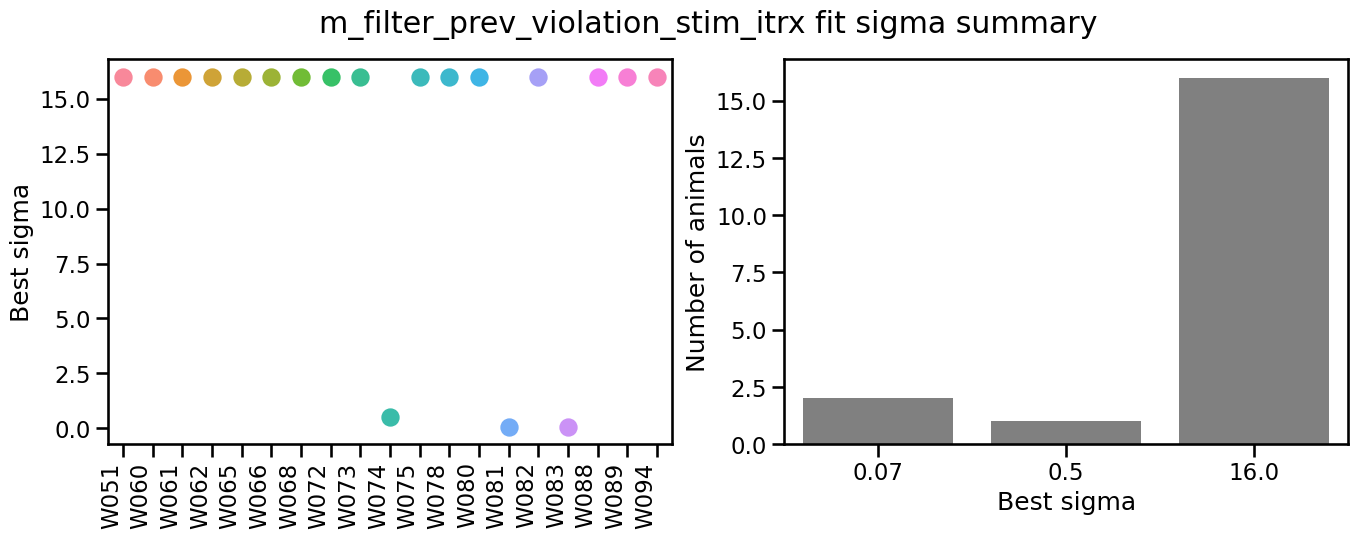

In [5]:
for model_name, model_df in df.groupby("model_name"):
    mvc.plot_sigma_summary(model_df, title=f"{model_name} fit sigma summary")

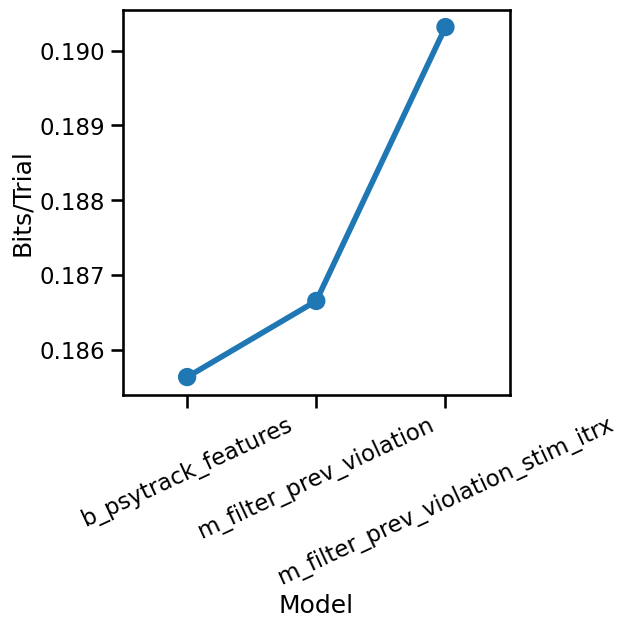

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
mvc.plot_model_comparison(hue=None, ax=ax, order=ORDER, ylim=None, errorbar=None)

In [52]:
bits_per_trial_df = mvc.compute_bits_per_trial_df()

In [57]:
model_summary = (
    bits_per_trial_df.groupby("model_name").bits_per_trial.mean().reset_index()
)

In [63]:
# Extracting values for the specified models
b_psytrack_value = model_summary[model_summary["model_name"] == "b_psytrack_features"][
    "bits_per_trial"
].values[0]
m_filter_prev_violation_stim_itrx_value = model_summary[
    model_summary["model_name"] == "m_filter_prev_violation_stim_itrx"
]["bits_per_trial"].values[0]
m_filter_prev_violation_value = model_summary[
    model_summary["model_name"] == "m_filter_prev_violation"
]["bits_per_trial"].values[0]

# Computing the differences
diff_stim_itrx = m_filter_prev_violation_stim_itrx_value - b_psytrack_value
diff_violation = m_filter_prev_violation_value - b_psytrack_value

print(f"Difference between binary and stim interaction : {diff_stim_itrx.round(4)}")
print(
    f"Difference between binary and violation interaction : {diff_violation.round(4)}"
)

Difference between binary and stim interaction : 0.0047
Difference between binary and violation interaction : 0.001


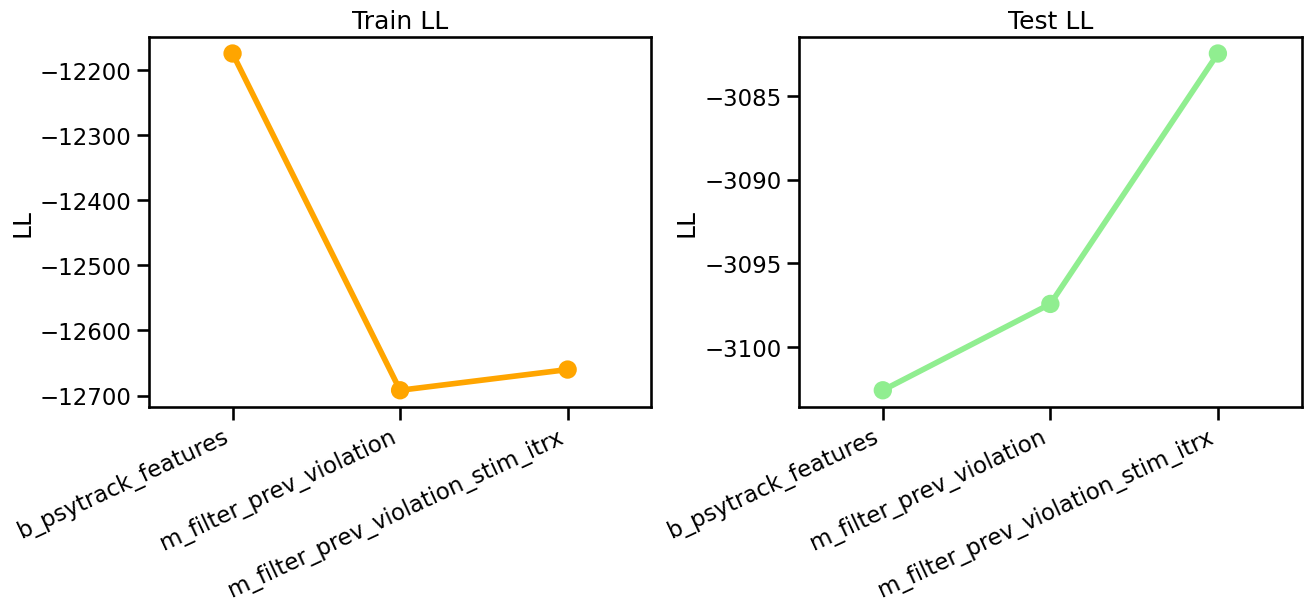

In [23]:
mvc.plot_train_and_test_ll(order=ORDER, errorbar=None)

In [35]:
best_fit = mvc.find_best_fit(["animal_id", "model_name"])
pivot_df = best_fit.pivot(index="animal_id", columns="model_name", values="nll")

pivot_df["m_prev_viol_intrx_ll_delta"] = (
    -1 * pivot_df["m_filter_prev_violation_stim_itrx"]
) - (-1 * pivot_df["b_psytrack_features"])

pivot_df["m_prev_viol_ll_delta"] = (-1 * pivot_df["m_filter_prev_violation"]) - (
    -1 * pivot_df["b_psytrack_features"]
)

In [49]:
pivot_df.head()

model_name,b_psytrack_features,m_filter_prev_violation,m_filter_prev_violation_all_itrx,m_filter_prev_violation_stim_itrx,m_psytrack_features,m_prev_viol_intrx_ll_delta,m_prev_viol_ll_delta
animal_id,,,,,,,
W051,6073.069550,6043.136340,5947.367226,6001.450873,6073.820098,71.618677,29.933211
W060,4013.420521,4005.590162,3971.382907,3979.639473,4007.453949,33.781047,7.830359
W061,2737.364350,2733.091677,2723.261091,2726.600336,2735.636417,10.764014,4.272673
W062,2080.553016,2076.828682,2068.485945,2069.021747,2076.411087,11.531269,3.724333
W065,3367.278693,3378.698851,3374.920342,3373.227710,3380.151807,-5.949017,-11.420158


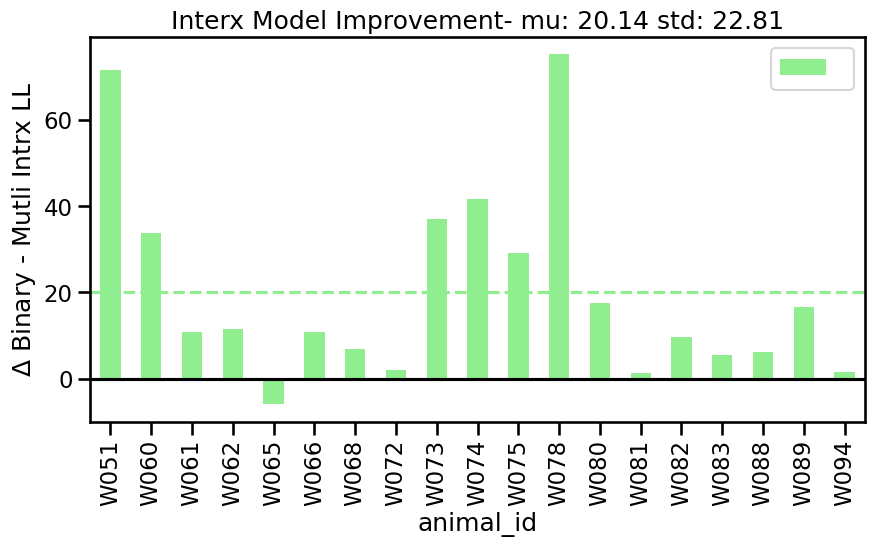

In [46]:
fig, ax = plt.subplots(figsize=(10, 5))

plot_column = "m_prev_viol_intrx_ll_delta"

pivot_df.reset_index().plot(
    kind="bar",
    x="animal_id",
    y=plot_column,
    ax=ax,
    label="",
    color="lightgreen",
)

mean = pivot_df[plot_column].mean().round(2)
std = pivot_df[plot_column].std().round(2)
ax.axhline(y=0, color="k")
ax.axhline(y=mean, color="lightgreen", linestyle="--")
_ = ax.set(
    # ylim=(-10, None),
    ylabel=f"$\Delta$ Binary - Mutli Intrx LL",
    title=f"Interx Model Improvement- mu: {mean} std: {std}",
)

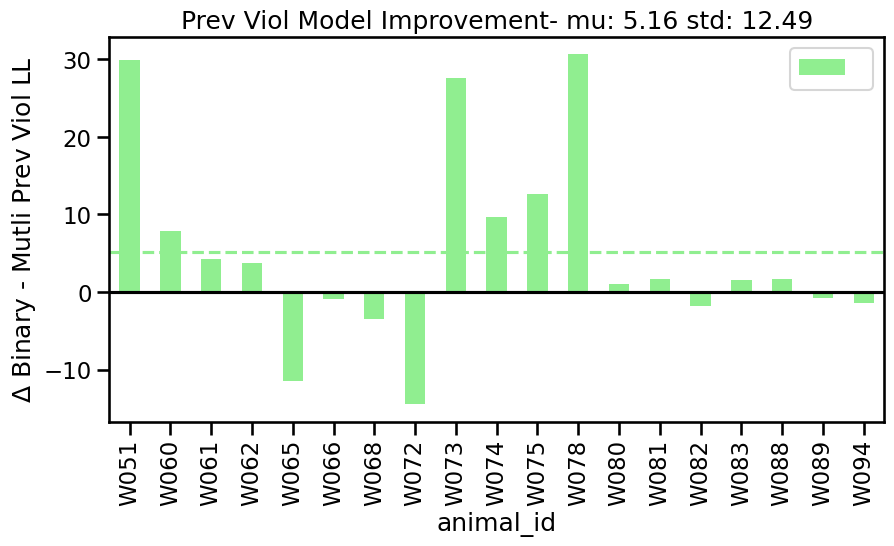

In [64]:
fig, ax = plt.subplots(figsize=(10, 5))

plot_column = "m_prev_viol_ll_delta"

pivot_df.reset_index().plot(
    kind="bar",
    x="animal_id",
    y=plot_column,
    ax=ax,
    label="",
    color="lightgreen",
)

mean = pivot_df[plot_column].mean().round(2)
std = pivot_df[plot_column].std().round(2)
ax.axhline(y=0, color="k")
ax.axhline(y=mean, color="lightgreen", linestyle="--")
_ = ax.set(
    # ylim=(-10, None),
    ylabel=f"$\Delta$ Binary - Mutli Prev Viol LL",
    title=f"Prev Viol Model Improvement- mu: {mean} std: {std}",
)